In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from os import path
from utils import plot_report

import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 20.0]
HDFStore=pd.HDFStore

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import numpy as np

import config

In [2]:
# training parameters
seed= config.seed

dr=0.2
lr2=1e-3
lr1=1e-4
lr=8e-4

num_epochs=1000
mini_batch_size=512

main_units=64
secondary_units=16
last_unit=8
lstm_units=64
num_classes=1

# radius or residues
feature='residues'

# if features is residues ''<coefficients>_' for example '17_' otherwhise ''
coefficients='_17'

print_sample=False

In [3]:
score = 'accuracy'

#this data has been previously processed by airflow
features = pd.read_csv("/data/elekin/data/results/handwriting/tmp/windowed_data_data_augmentation_{}_20220909{}.csv".format(feature, coefficients)) #TODO automate
features = features.set_index(features.columns[0]).sort_index()
print("Loaded data from CSV")
features.head(10)

Loaded data from CSV


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
C01_1,0.000000,139.606018,12.253823,74.690512,11.408070,53.418940,16.638002,35.400345,12.710705,31.302645,...,14.152344,11.462339,4.882244,5.308954,13.849044,13.251287,5.856435,6.324626,12.959543,14.810356
C01_1,139.606018,12.253823,74.690512,11.408070,53.418940,16.638002,35.400345,12.710705,31.302645,17.700574,...,11.462339,4.882244,5.308954,13.849044,13.251287,5.856435,6.324626,12.959543,14.810356,10.134705
C01_1,12.253823,74.690512,11.408070,53.418940,16.638002,35.400345,12.710705,31.302645,17.700574,20.821569,...,4.882244,5.308954,13.849044,13.251287,5.856435,6.324626,12.959543,14.810356,10.134705,10.729681
C01_1,74.690512,11.408070,53.418940,16.638002,35.400345,12.710705,31.302645,17.700574,20.821569,13.691473,...,5.308954,13.849044,13.251287,5.856435,6.324626,12.959543,14.810356,10.134705,10.729681,15.004039
C01_1,11.408070,53.418940,16.638002,35.400345,12.710705,31.302645,17.700574,20.821569,13.691473,20.877784,...,13.849044,13.251287,5.856435,6.324626,12.959543,14.810356,10.134705,10.729681,15.004039,17.818776
C01_1,53.418940,16.638002,35.400345,12.710705,31.302645,17.700574,20.821569,13.691473,20.877784,17.468618,...,13.251287,5.856435,6.324626,12.959543,14.810356,10.134705,10.729681,15.004039,17.818776,14.849591
C01_1,16.638002,35.400345,12.710705,31.302645,17.700574,20.821569,13.691473,20.877784,17.468618,15.251673,...,5.856435,6.324626,12.959543,14.810356,10.134705,10.729681,15.004039,17.818776,14.849591,15.154547
C01_1,35.400345,12.710705,31.302645,17.700574,20.821569,13.691473,20.877784,17.468618,15.251673,15.382106,...,6.324626,12.959543,14.810356,10.134705,10.729681,15.004039,17.818776,14.849591,15.154547,18.476559
C01_1,12.710705,31.302645,17.700574,20.821569,13.691473,20.877784,17.468618,15.251673,15.382106,14.377216,...,12.959543,14.810356,10.134705,10.729681,15.004039,17.818776,14.849591,15.154547,18.476559,21.566877


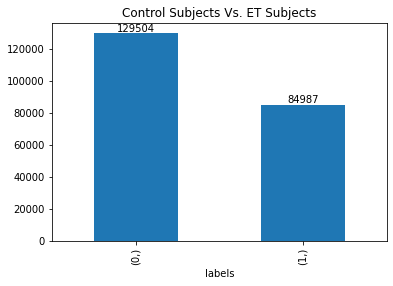

In [4]:
labels = pd.read_csv("/data/elekin/data/results/handwriting/tmp/windowed_data_data_augmentation_{}_20220909_17_labels.csv".format(feature, coefficients), index_col=0) #TODO automate
ax = labels.value_counts().plot.bar(title='Control Subjects Vs. ET Subjects', x='counts')
_ = ax.bar_label(ax.containers[0])

In [5]:
np.array_equal(features.index.values, labels.index.values)

True

In [6]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(labels).astype(np.int16)
y.shape
#binary labels
#le = LabelEncoder().fit(labels.values.ravel())
#y = le.fit_transform(labels.values.ravel()).astype(np.int16)
#y

(214491, 1)

In [7]:
X=features.values.astype(np.float64)
X.shape

(214491, 50)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=38)

In [9]:
x_train.shape, x_test.shape

((143708, 50), (70783, 50))

In [10]:
num_features = x_train.shape[1]

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).take(len(x_train)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).take(len(x_test)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
steps_per_epoch = round(len(train_dataset)/mini_batch_size)

if print_sample:
    for feat, targ in test_dataset.take(10):
        print ('Features test: {}, Target: {}'.format(feat, targ))

    for feat, targ in test_dataset.take(10):
        print ('Features train: {}, Target: {}'.format(feat, targ))

print("{0} train batches and {1} test batches of {2} mini batch size and {3} steps per epoch".format(len(train_dataset), 
                                                                              len(test_dataset),
                                                                              mini_batch_size,
                                                                                steps_per_epoch))

281 train batches and 139 test batches of 512 mini batch size and 1 steps per epoch


## FCNN ARCHITECTURE ANALISYS

Some training helpers functions

In [12]:
# #Early stop configuration
earlystop_callback = EarlyStopping(
  monitor='val_accuracy', min_delta=1e-3,
  patience=200)

training_earlystop_callback = EarlyStopping(
  monitor='accuracy', min_delta=1e-4,
  patience=200)

def get_callbacks(name):
    return [
        #tfdocs.modeling.EpochDots(),
        earlystop_callback,
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, min_delta=1e-5),
        #tf.keras.callbacks.TensorBoard(logdir/name),
      ]

def compile_and_fit(model, train_dataset, test_dataset, name, optimizer=None, max_epochs=1000):
    tf.keras.backend.clear_session()# avoid clutter from old models and layers, especially when memory is limited
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    tf.random.set_seed(seed) # establecemos la semilla para tensorflow
    history = model.fit(train_dataset, 
                        use_multiprocessing=True, 
                        validation_data=test_dataset, epochs=max_epochs, 
                        callbacks=get_callbacks(name),
                        verbose=1, shuffle=False)
    return history

# Many models train better if you gradually reduce the learning rate during training. 
# Use optimizers.schedules to reduce the learning rate over time:
def get_optimizer(steps_per_epoch=1, lr=1e-4, multiplier=1000):
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(lr,
                                                                 decay_steps=steps_per_epoch*multiplier,
                                                                 decay_rate=1,
                                                                 staircase=False)
    return tf.keras.optimizers.Adam(lr_schedule)

In [13]:
size_histories = {}

In [14]:
tiny = tf.keras.models.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)])

size_histories['fcnn/tiny'] = compile_and_fit(tiny, train_dataset, 
                                              test_dataset,
                                              "fcnn/tiny", 
#                                               optimizer=get_optimizer(),
                                              optimizer=tf.keras.optimizers.Adam(lr), 
#                                               optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=num_epochs)

print("\n#######################Evaluation###########################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/tiny'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/tiny'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3264      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,329
Trainable params: 3,329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6026 - val_loss: nan - val_accuracy: 0.6049
Epoch 2/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 3/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 4/1000
281/281 [==============

281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 56/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 57/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 58/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 59/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 60/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 61/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 62/1000
281/281 [==================

Epoch 114/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 115/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 116/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 117/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 118/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 119/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 120/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 121/1000
281/2

281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 173/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 174/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 175/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 176/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 177/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 178/1000
281/281 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 179/1000
281/281 [===========

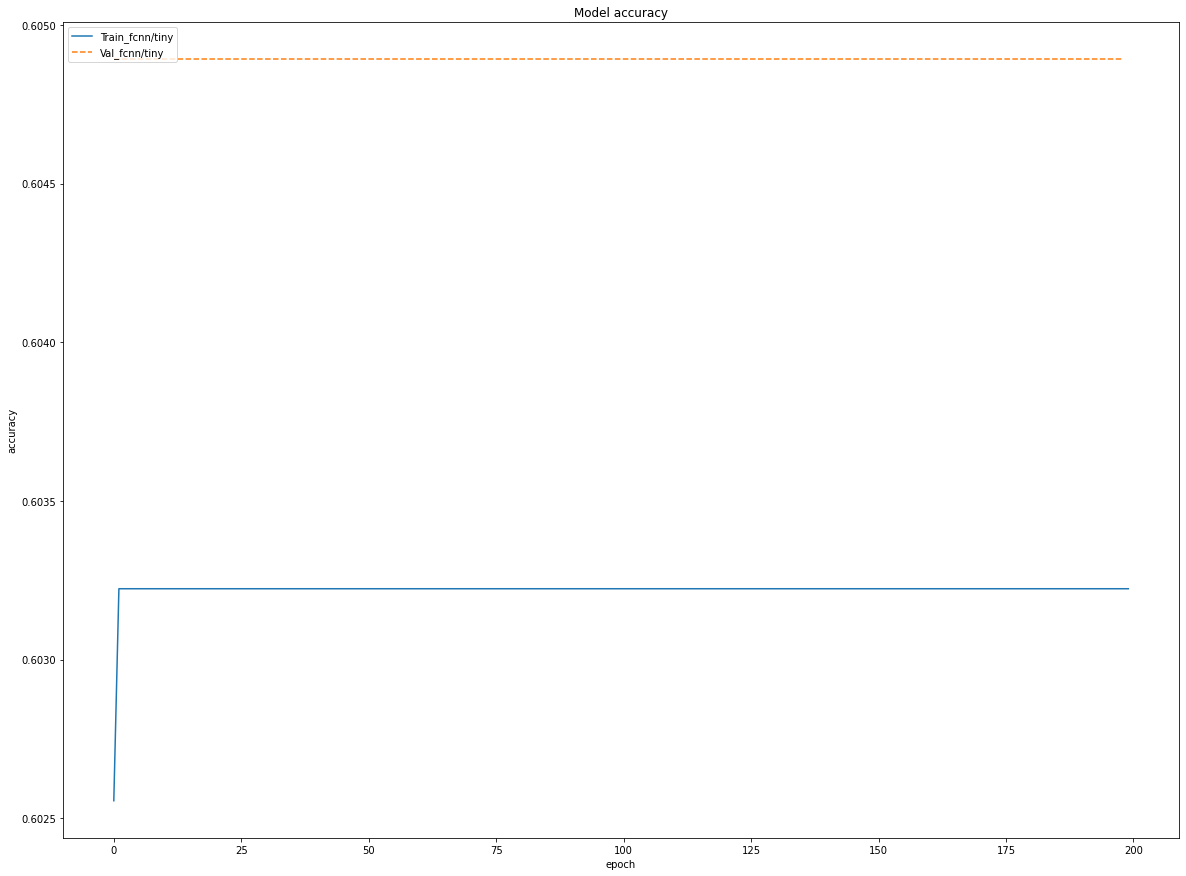

In [15]:
mpl.rcParams['figure.figsize'] = [20.0, 15.0]
plot_report(size_histories, metric='accuracy')

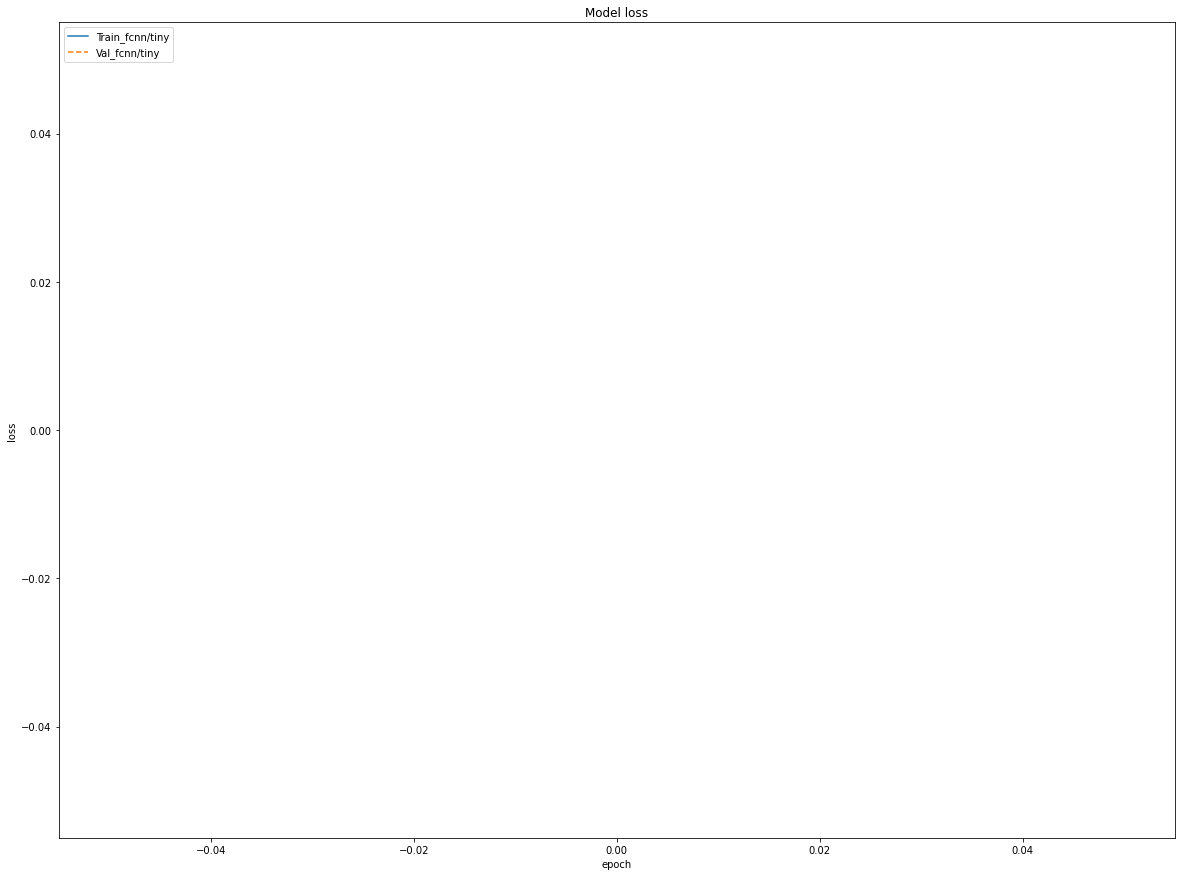

In [16]:
plot_report(size_histories, 'loss')

In [17]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
size_histories['fcnn/small'] = compile_and_fit(small_model, train_dataset, 
                                              test_dataset,'fcnn/small',
#                                               optimizer=get_optimizer(),
                                              optimizer=tf.keras.optimizers.Adam(lr), 
#                                               optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=num_epochs)

print("\n#######################Evaluation###########################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/small'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/small'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3264      
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,321
Trainable params: 4,321
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 2/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 3/1000
281/281 [====================

281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 55/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 56/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 57/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 58/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 59/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 60/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 61/1000
281/281 [==================

Epoch 113/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 114/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 115/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 116/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 117/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 118/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 119/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 120/1000
281/2

281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 172/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 173/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 174/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 175/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 176/1000
281/281 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 177/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 178/1000
281/281 [===========

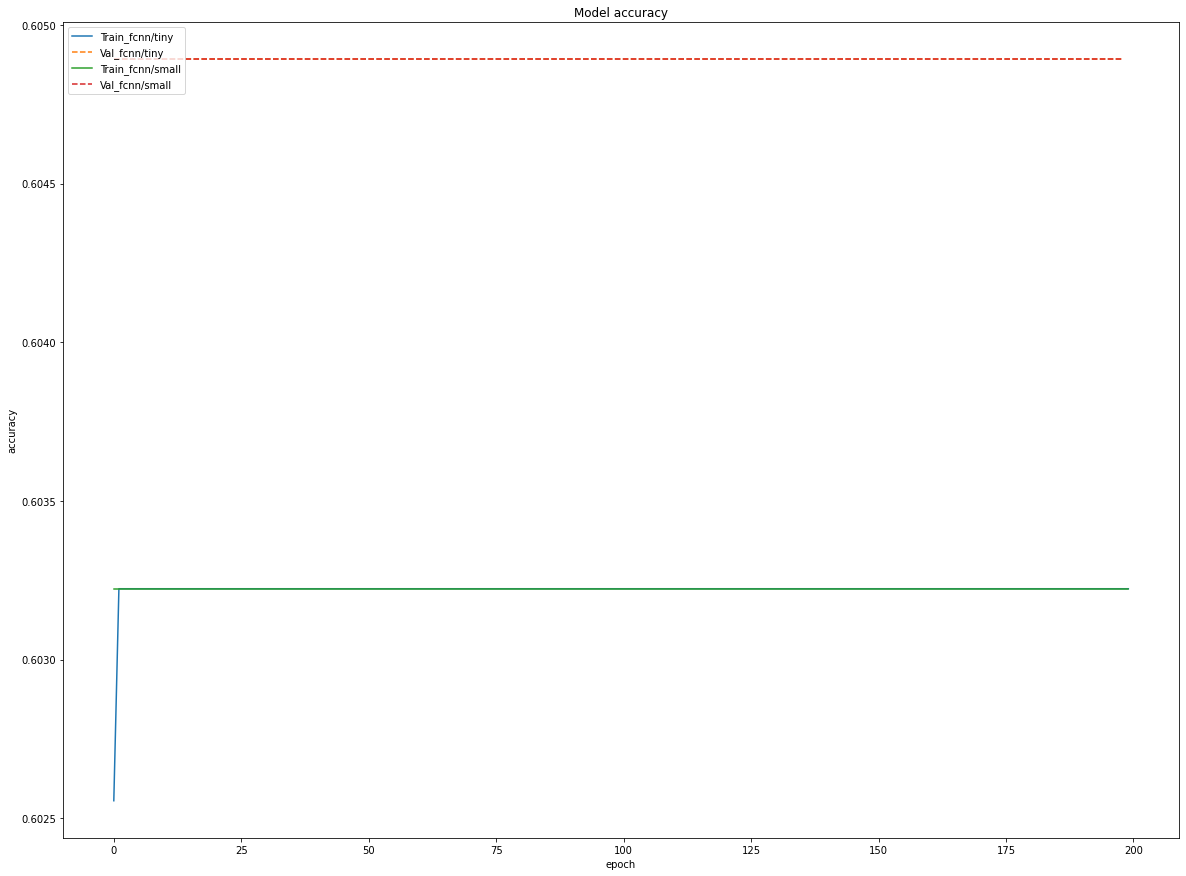

In [18]:
plot_report(size_histories)

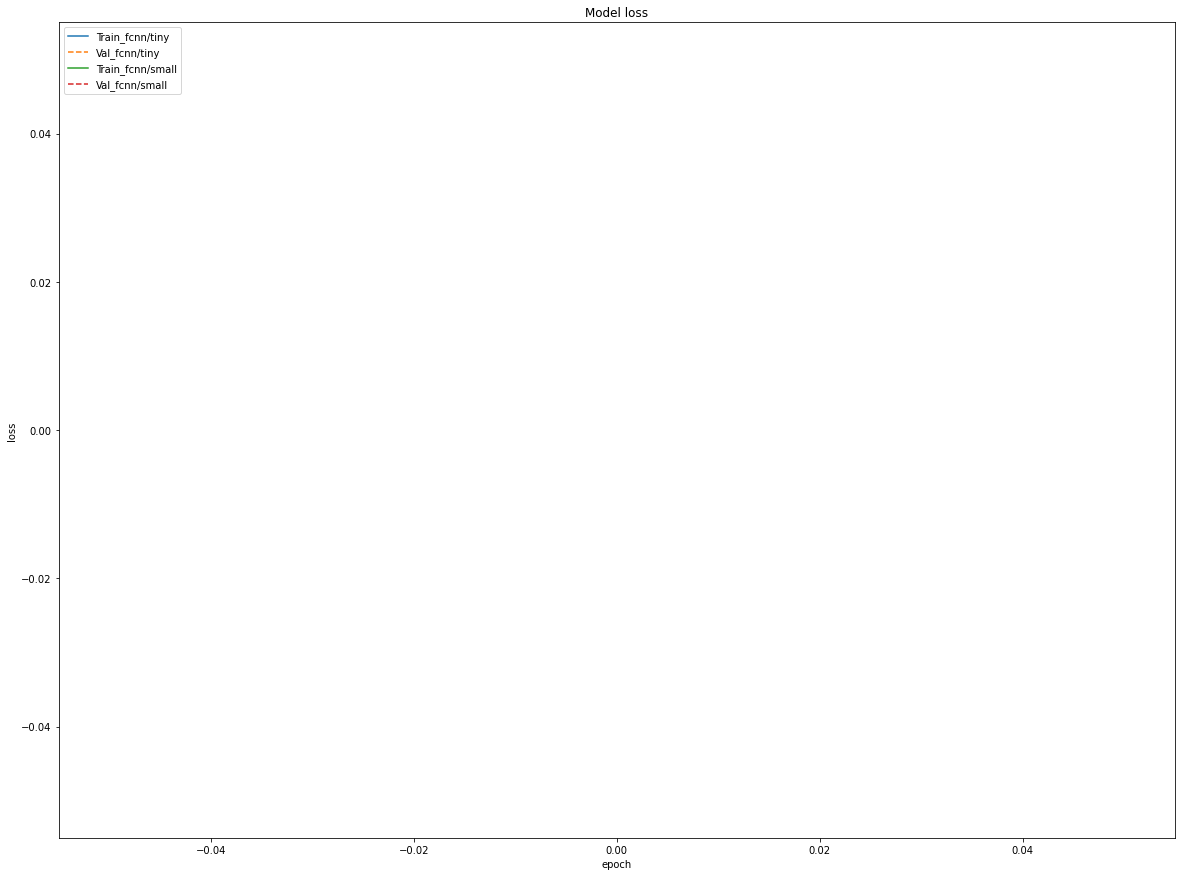

In [19]:
plot_report(size_histories, 'loss')

In [20]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
large_model = tf.keras.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)),  
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
size_histories['fcnn/large'] = compile_and_fit(large_model, train_dataset, 
                                              test_dataset, "fcnn/large",
                                              optimizer=tf.keras.optimizers.Adam(lr), 
#                                               optimizer=get_optimizer(), 
                                              max_epochs=num_epochs)

print("Evaluation")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/large'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/large'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3264      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,609
Trainable params: 8,609
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
281/281 [==============================] 

281/281 [==============================] - 1s 2ms/step - loss: 4.7299e-08 - accuracy: 0.3968 - val_loss: 4.7101e-08 - val_accuracy: 0.3952
Epoch 48/1000
281/281 [==============================] - 1s 2ms/step - loss: 4.7299e-08 - accuracy: 0.3968 - val_loss: 4.7101e-08 - val_accuracy: 0.3952
Epoch 49/1000
281/281 [==============================] - 1s 2ms/step - loss: 4.7299e-08 - accuracy: 0.3968 - val_loss: 4.7101e-08 - val_accuracy: 0.3952
Epoch 50/1000
281/281 [==============================] - 1s 2ms/step - loss: 4.7299e-08 - accuracy: 0.3968 - val_loss: 4.7101e-08 - val_accuracy: 0.3952
Epoch 51/1000
281/281 [==============================] - 1s 2ms/step - loss: 4.7299e-08 - accuracy: 0.3968 - val_loss: 4.7101e-08 - val_accuracy: 0.3952
Epoch 52/1000
281/281 [==============================] - 1s 2ms/step - loss: 4.7299e-08 - accuracy: 0.3968 - val_loss: 4.7101e-08 - val_accuracy: 0.3952
Epoch 53/1000
281/281 [==============================] - 1s 2ms/step - loss: 4.7299e-08 - accura

281/281 [==============================] - 1s 2ms/step - loss: 4.7299e-08 - accuracy: 0.3968 - val_loss: 4.7101e-08 - val_accuracy: 0.3952
Epoch 101/1000
281/281 [==============================] - 1s 2ms/step - loss: 4.7299e-08 - accuracy: 0.3968 - val_loss: 4.7101e-08 - val_accuracy: 0.3952
Epoch 102/1000
281/281 [==============================] - 1s 2ms/step - loss: 4.7299e-08 - accuracy: 0.3968 - val_loss: 4.7101e-08 - val_accuracy: 0.3952
Epoch 103/1000
281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accuracy: 0.3968 - val_loss: 4.7101e-08 - val_accuracy: 0.3952
Epoch 104/1000
281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accuracy: 0.3968 - val_loss: 4.7101e-08 - val_accuracy: 0.3952
Epoch 105/1000
281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accuracy: 0.3968 - val_loss: 4.7101e-08 - val_accuracy: 0.3952
Epoch 106/1000
281/281 [==============================] - 1s 2ms/step - loss: 4.7299e-08 - 

281/281 [==============================] - 1s 2ms/step - loss: 4.7299e-08 - accuracy: 0.3968 - val_loss: 4.7101e-08 - val_accuracy: 0.3952
Epoch 154/1000
281/281 [==============================] - 1s 2ms/step - loss: 4.7299e-08 - accuracy: 0.3968 - val_loss: 4.7101e-08 - val_accuracy: 0.3952
Epoch 155/1000
281/281 [==============================] - 1s 2ms/step - loss: 4.7299e-08 - accuracy: 0.3968 - val_loss: 4.7101e-08 - val_accuracy: 0.3952
Epoch 156/1000
281/281 [==============================] - 1s 2ms/step - loss: 4.7299e-08 - accuracy: 0.3968 - val_loss: 4.7101e-08 - val_accuracy: 0.3952
Epoch 157/1000
281/281 [==============================] - 1s 2ms/step - loss: 4.7299e-08 - accuracy: 0.3968 - val_loss: 4.7101e-08 - val_accuracy: 0.3952
Epoch 158/1000
281/281 [==============================] - 1s 2ms/step - loss: 4.7299e-08 - accuracy: 0.3968 - val_loss: 4.7101e-08 - val_accuracy: 0.3952
Epoch 159/1000
281/281 [==============================] - 1s 2ms/step - loss: 4.7299e-08 - 

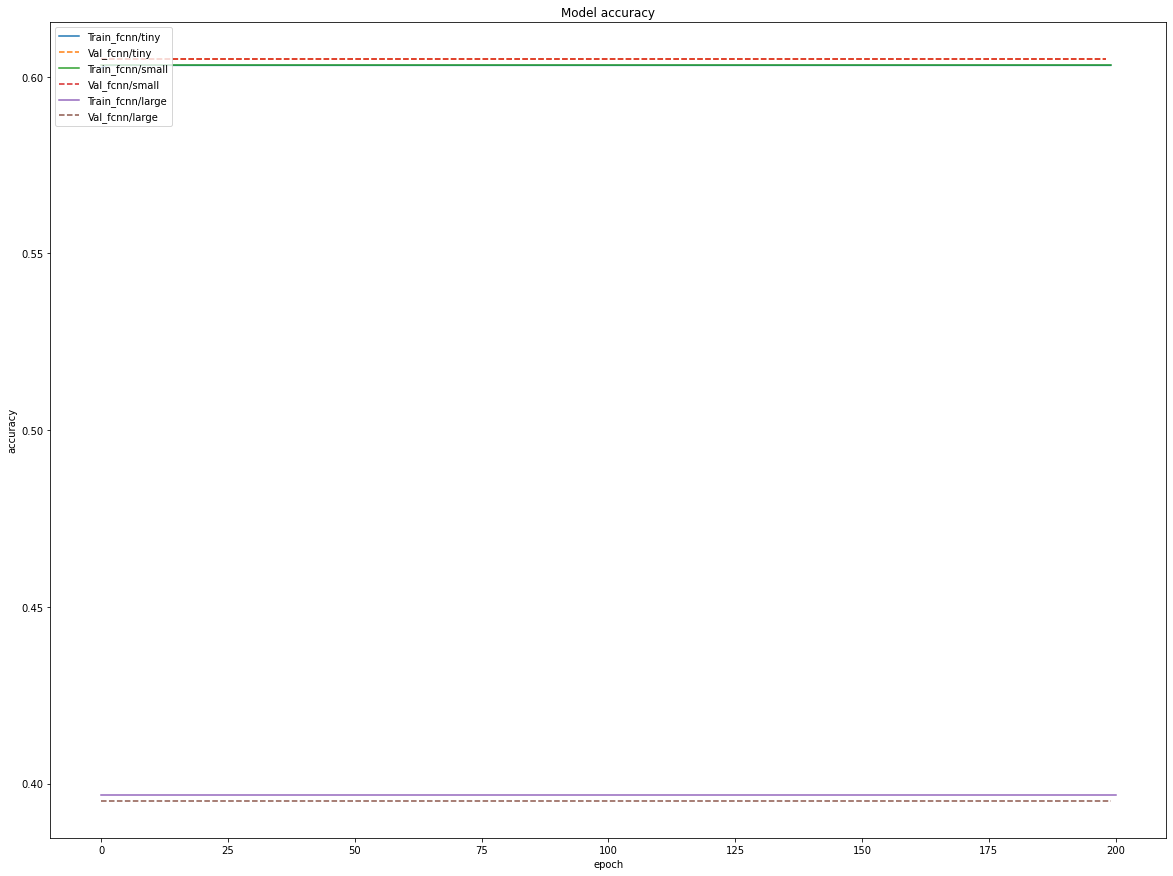

In [21]:
plot_report(size_histories)

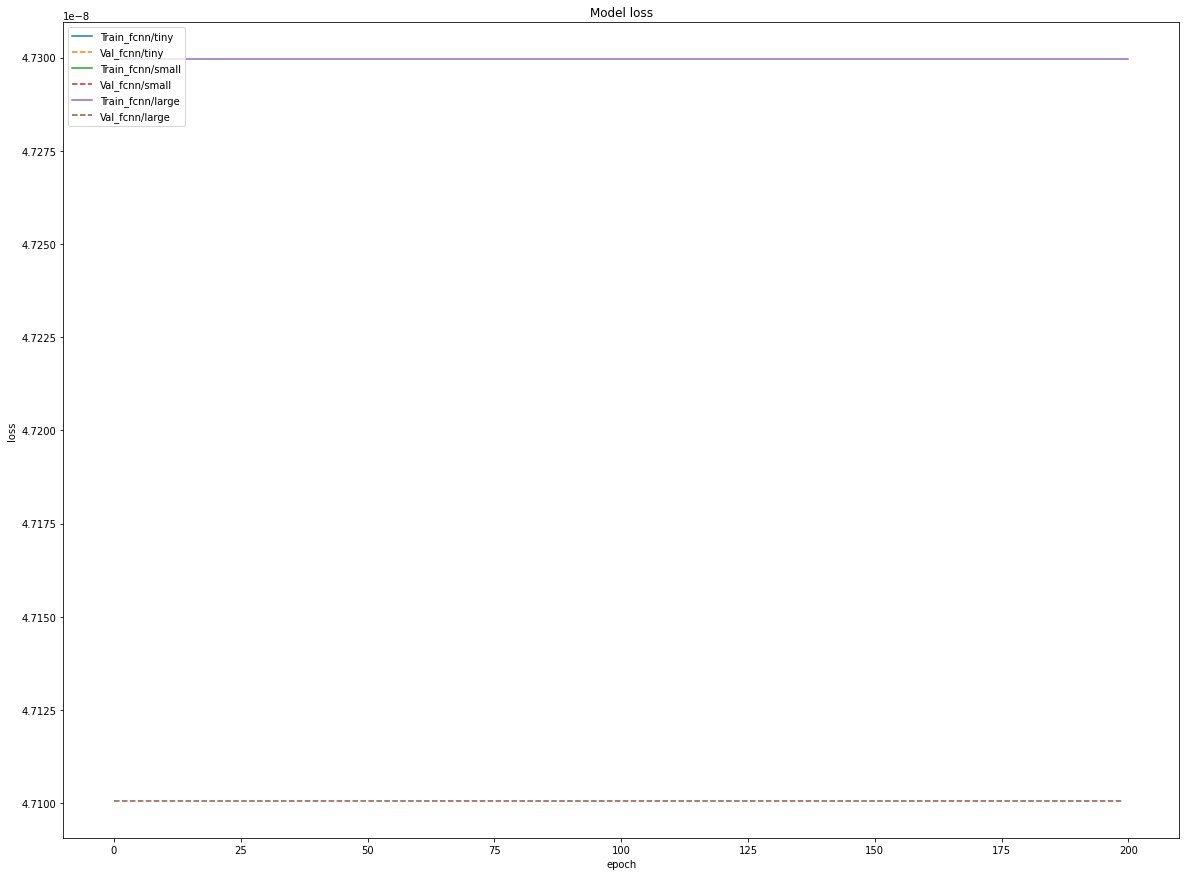

In [22]:
plot_report(size_histories, 'loss')

### Dropout

Although we got an accuracy of 0.75 looking at loss function chart is pretty obvious: There is overfiting. Now we have an overfitted NN let's make some adjustments to improve generalization capacity startin from dropout techniques.  

In [23]:
tiny_dropout = tf.keras.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
size_histories['fcnn/tiny/dropout'] = compile_and_fit(tiny_dropout, 
                                                      train_dataset,
                                                      test_dataset,
                                                      "fcnn/tiny/dropout", 
                                                      optimizer=tf.keras.optimizers.Adam(lr), 
                                                      max_epochs=num_epochs)

print("\n#######################EVALUATIO######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/tiny/dropout'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/tiny/dropout'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3264      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 1)                 9

281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 51/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 52/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 53/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 54/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 55/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 56/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 57/1000
281/281 [==================

Epoch 109/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 110/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 111/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 112/1000
281/281 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 113/1000
281/281 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 114/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 115/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 116/1000
281/2

281/281 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 168/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 169/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 170/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 171/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 172/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 173/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 174/1000
281/281 [===========

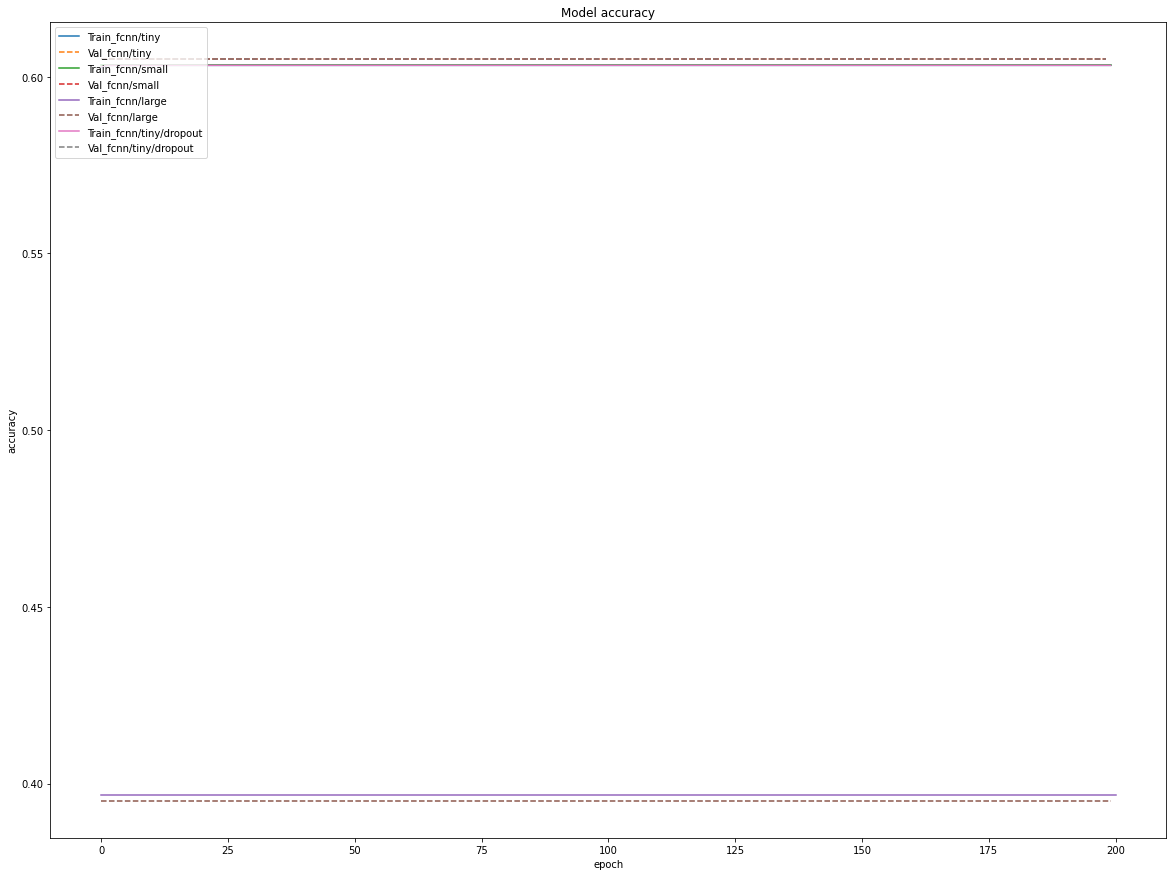

In [24]:
plot_report(size_histories)

Validation accuracy keeps improving more epoch with a total improvement from 0.75 to 0.81. Furthemore, the gap between training loss function and test loss function has been reduced.

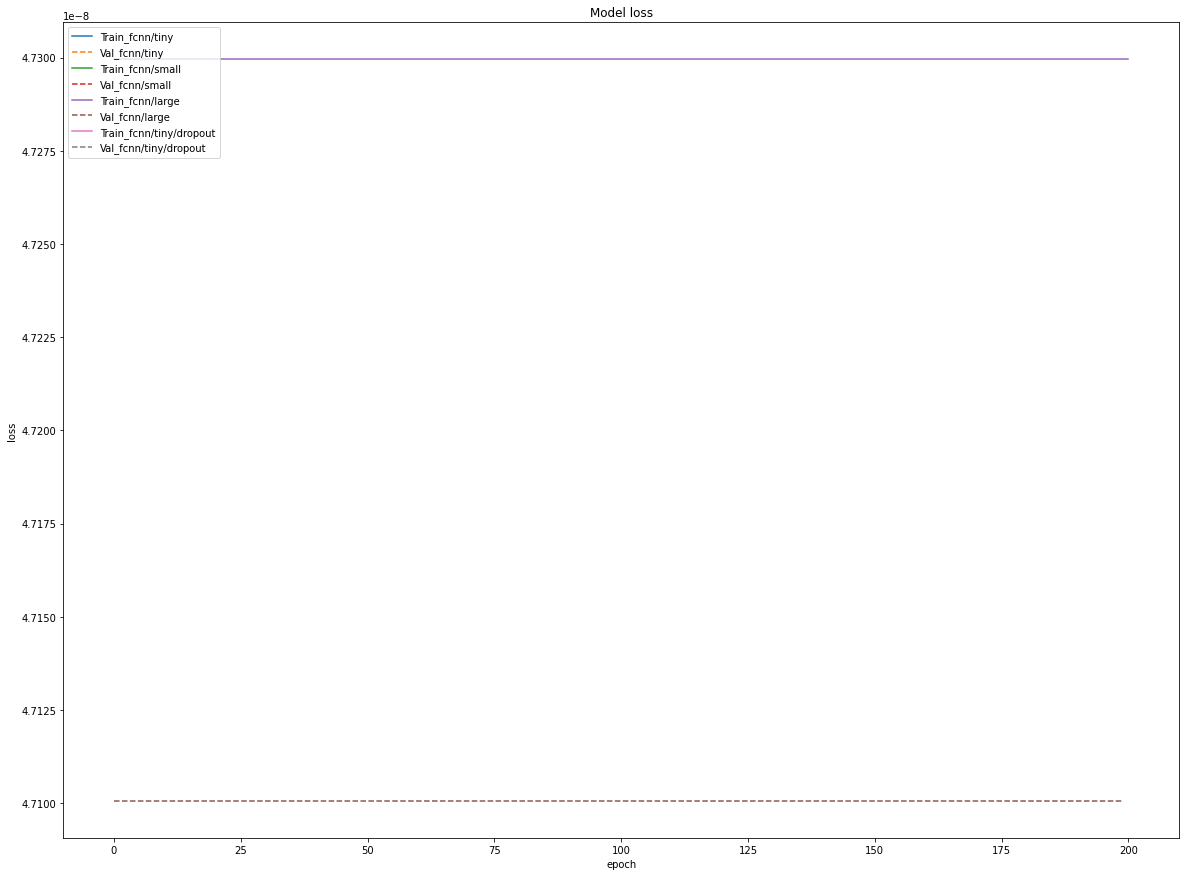

In [25]:
plot_report(size_histories, metric='loss')

### Kernel regularizer

In [26]:
# shutil.rmtree(logdir/'regularizers/tiny', ignore_errors=True)
# shutil.copytree(logdir/'fcnn/tiny', logdir/'regularizers/tiny')
regularizer_histories = {}
regularizer_histories['large'] = size_histories['fcnn/large']
regularizer_histories['dropout'] = size_histories['fcnn/tiny/dropout']

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights. one reason why L2 is more common.

In tf.keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.

In [27]:
l2_model = tf.keras.Sequential([
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1),
                 input_shape=(num_features,)),
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(secondary_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(last_unit, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
regularizer_histories['l2'] = compile_and_fit(l2_model, train_dataset, 
                                              test_dataset, 
                                              optimizer=tf.keras.optimizers.Adam(lr),
                                              name="regularizers/l2")
# Evaluate the model on the test data using `evaluate`
print("\n#######################EVALUATIO######################")
print('test acc:', max(regularizer_histories['l2'].history["val_accuracy"]))
print('train acc:', max(regularizer_histories['l2'].history["accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3264      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,609
Trainable params: 8,609
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
281/281 [==============================] 

281/281 [==============================] - 1s 2ms/step - loss: 8.6359e-05 - accuracy: 0.6032 - val_loss: 8.6246e-05 - val_accuracy: 0.6049
Epoch 48/1000
281/281 [==============================] - 1s 2ms/step - loss: 8.6355e-05 - accuracy: 0.6032 - val_loss: 8.6282e-05 - val_accuracy: 0.6049
Epoch 49/1000
281/281 [==============================] - 1s 2ms/step - loss: 8.6362e-05 - accuracy: 0.6032 - val_loss: 8.5694e-05 - val_accuracy: 0.6049
Epoch 50/1000
281/281 [==============================] - 1s 2ms/step - loss: 8.6344e-05 - accuracy: 0.6032 - val_loss: 8.5940e-05 - val_accuracy: 0.6049
Epoch 51/1000
281/281 [==============================] - 1s 2ms/step - loss: 8.6369e-05 - accuracy: 0.6032 - val_loss: 8.6747e-05 - val_accuracy: 0.6049
Epoch 52/1000
281/281 [==============================] - 1s 2ms/step - loss: 8.6344e-05 - accuracy: 0.6032 - val_loss: 8.6427e-05 - val_accuracy: 0.6049
Epoch 53/1000
281/281 [==============================] - 1s 2ms/step - loss: 8.6348e-05 - accura

281/281 [==============================] - 1s 2ms/step - loss: 8.6237e-05 - accuracy: 0.6032 - val_loss: 8.7019e-05 - val_accuracy: 0.6049
Epoch 101/1000
281/281 [==============================] - 1s 2ms/step - loss: 8.6233e-05 - accuracy: 0.6032 - val_loss: 8.6267e-05 - val_accuracy: 0.6049
Epoch 102/1000
281/281 [==============================] - 1s 2ms/step - loss: 8.6235e-05 - accuracy: 0.6032 - val_loss: 8.6423e-05 - val_accuracy: 0.6049
Epoch 103/1000
281/281 [==============================] - 1s 2ms/step - loss: 8.6240e-05 - accuracy: 0.6032 - val_loss: 8.6897e-05 - val_accuracy: 0.6049
Epoch 104/1000
281/281 [==============================] - 1s 2ms/step - loss: 8.6236e-05 - accuracy: 0.6032 - val_loss: 8.5118e-05 - val_accuracy: 0.6049
Epoch 105/1000
281/281 [==============================] - 1s 2ms/step - loss: 8.6228e-05 - accuracy: 0.6032 - val_loss: 8.5584e-05 - val_accuracy: 0.6049
Epoch 106/1000
281/281 [==============================] - 1s 2ms/step - loss: 8.6241e-05 - 

281/281 [==============================] - 1s 2ms/step - loss: 8.6215e-05 - accuracy: 0.6032 - val_loss: 8.5733e-05 - val_accuracy: 0.6049
Epoch 154/1000
281/281 [==============================] - 1s 2ms/step - loss: 8.6209e-05 - accuracy: 0.6032 - val_loss: 8.5405e-05 - val_accuracy: 0.6049
Epoch 155/1000
281/281 [==============================] - 1s 2ms/step - loss: 8.6213e-05 - accuracy: 0.6032 - val_loss: 8.6725e-05 - val_accuracy: 0.6049
Epoch 156/1000
281/281 [==============================] - 1s 2ms/step - loss: 8.6193e-05 - accuracy: 0.6032 - val_loss: 8.7278e-05 - val_accuracy: 0.6049
Epoch 157/1000
281/281 [==============================] - 1s 2ms/step - loss: 8.6211e-05 - accuracy: 0.6032 - val_loss: 8.6665e-05 - val_accuracy: 0.6049
Epoch 158/1000
281/281 [==============================] - 1s 2ms/step - loss: 8.6191e-05 - accuracy: 0.6032 - val_loss: 8.5650e-05 - val_accuracy: 0.6049
Epoch 159/1000
281/281 [==============================] - 1s 2ms/step - loss: 8.6193e-05 - 

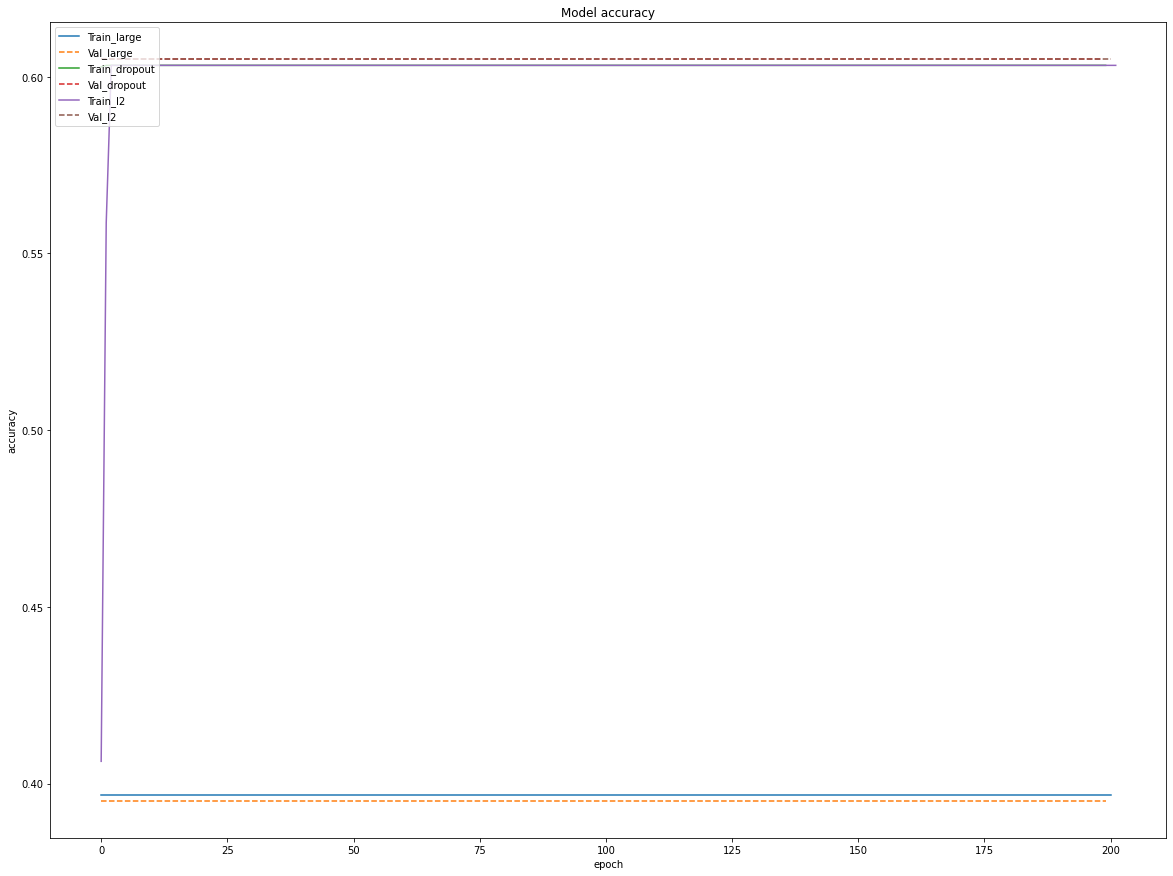

In [28]:
plot_report(regularizer_histories, 'accuracy')

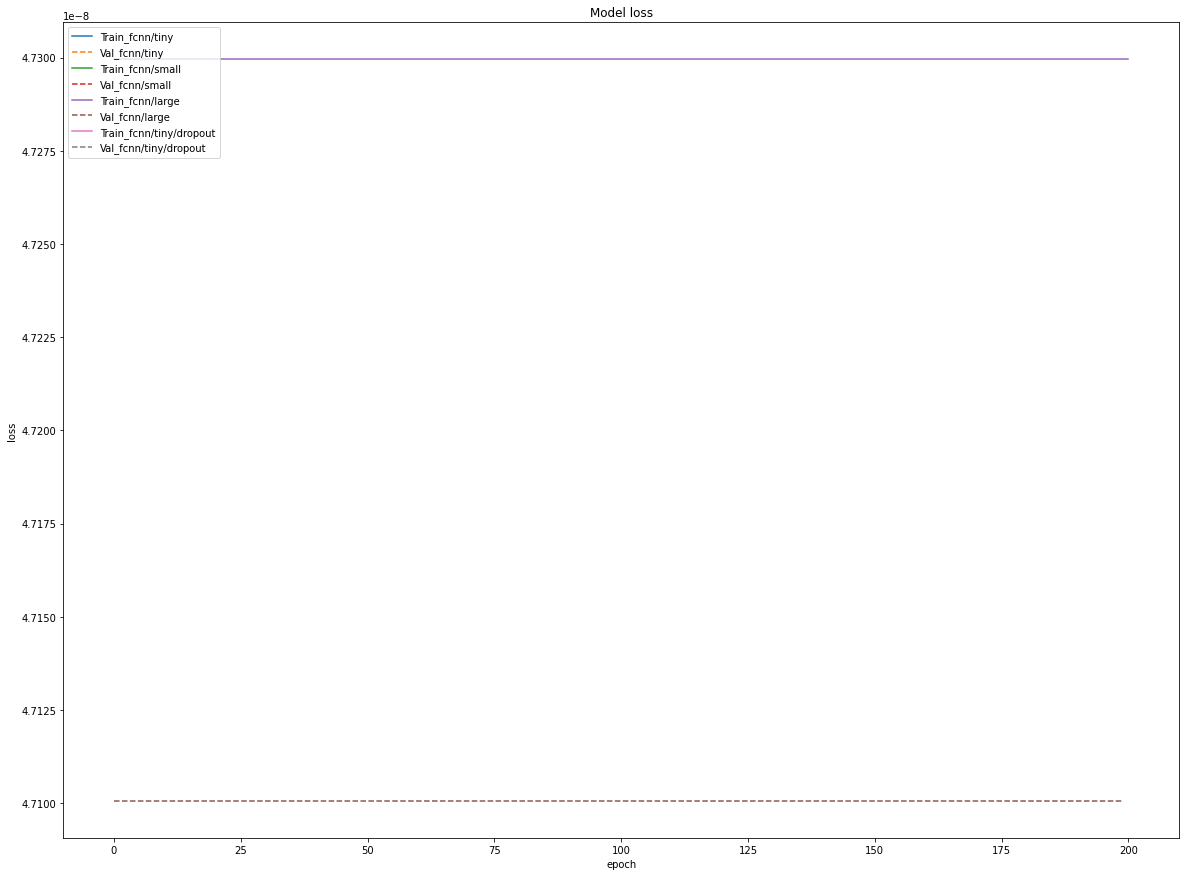

In [29]:
plot_report(size_histories, 'loss')

Now let's see what happens combining both techniques

In [30]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
combined_model = tf.keras.Sequential([
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1),
                 input_shape=(num_features,)),
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(secondary_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(last_unit, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    tf.keras.layers.Dropout(dr),
    layers.Dense(num_classes, activation=tf.nn.sigmoid)
])

tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
regularizer_histories['combined'] = compile_and_fit(combined_model, train_dataset, test_dataset, "regularizers/combined",
                                                   optimizer=get_optimizer())

# Evaluate the model on the test data using `evaluate`
print()
print('test acc:', max(regularizer_histories['combined'].history["val_accuracy"]))
print('train acc:', max(regularizer_histories['combined'].history["accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3264      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,609
Trainable params: 8,609
Non-trainabl

281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 52/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 53/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 54/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 55/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 56/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 57/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 58/1000
281/281 [==================

Epoch 110/1000
281/281 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 111/1000
281/281 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 112/1000
281/281 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 113/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 114/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 115/1000
281/281 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 116/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 117/1000
281/2

281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 169/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 170/1000
281/281 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 171/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 172/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 173/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 174/1000
281/281 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.6032 - val_loss: nan - val_accuracy: 0.6049
Epoch 175/1000
281/281 [===========

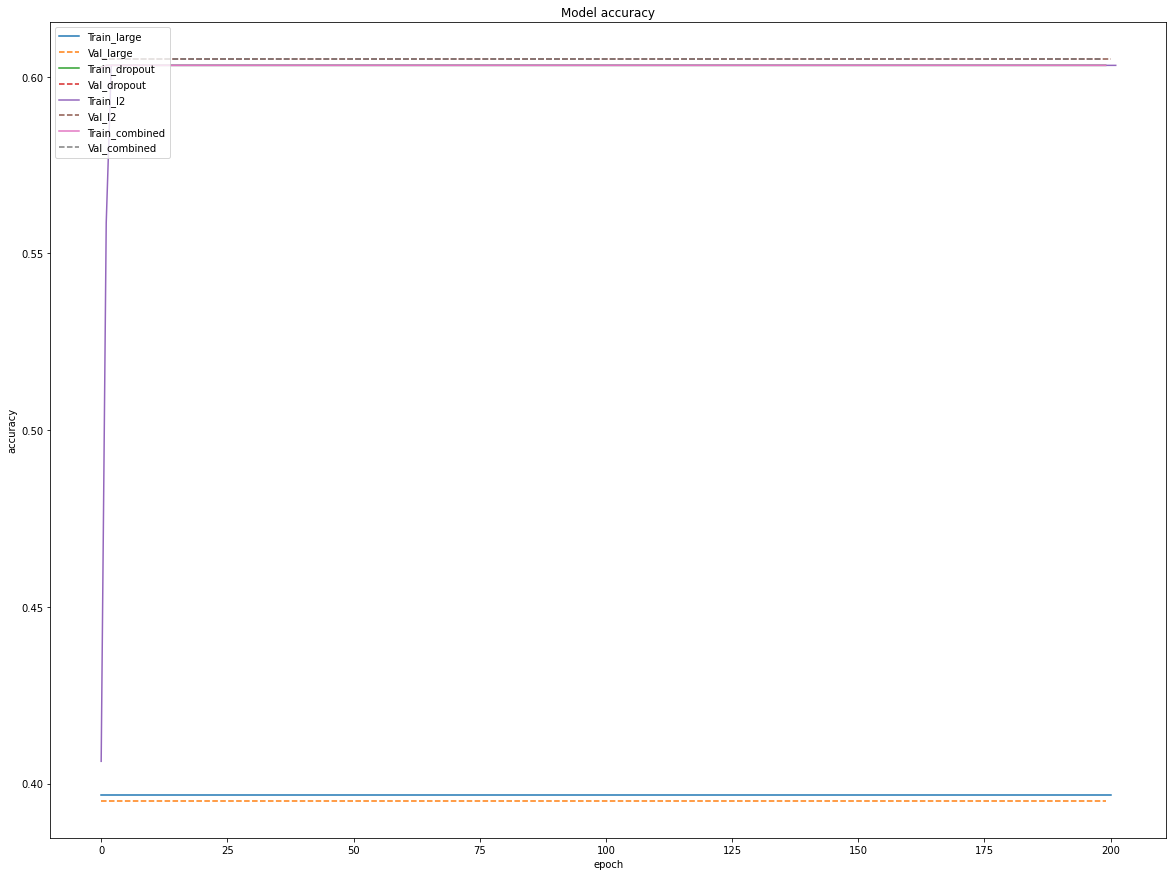

In [31]:
plot_report(regularizer_histories, 'accuracy')

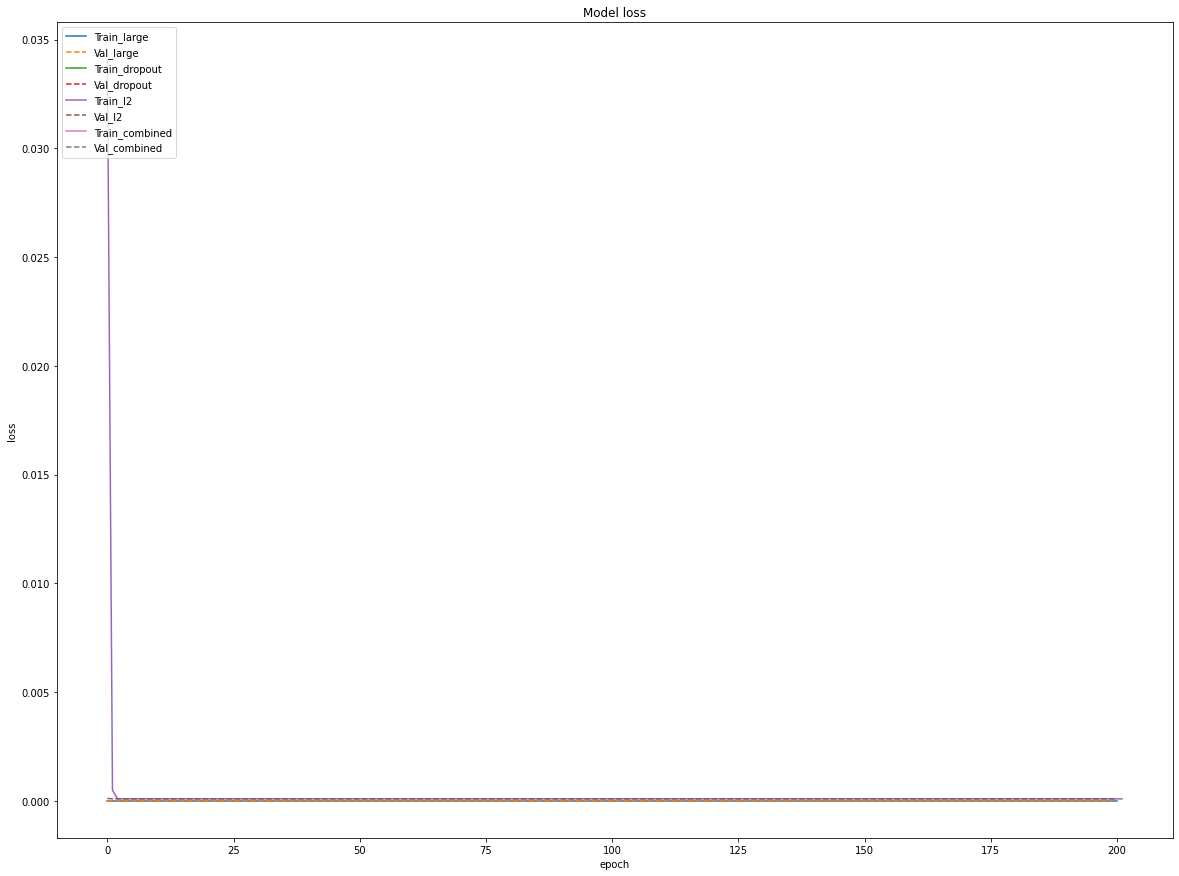

In [32]:
plot_report(regularizer_histories, 'loss')

## Batch Normalization

Batch normalization (also known as batch norm) is a method used to make artificial neural networks faster and more stable through normalization of the input layer by re-centering and re-scaling. It was proposed by Sergey Ioffe and Christian Szegedy in 2015.

[Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

[Tensorflow implementation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)


In [33]:
batch_histories = {}
batch_histories['large'] = size_histories['fcnn/large']
batch_histories['dropout'] = size_histories['fcnn/tiny/dropout']

In [34]:
small_batch = tf.keras.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
batch_histories['fcnn/small/batch'] = compile_and_fit(small_batch, 
                                                      train_dataset,
                                                      test_dataset,
                                                      "fcnn/small/batch", 
                                                      optimizer=tf.keras.optimizers.Adam(lr), 
                                                      max_epochs=num_epochs)

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(batch_histories['fcnn/small/batch'].history["accuracy"]))
print('test acc:', max(batch_histories['fcnn/small/batch'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3264      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 batch_normalization_2 (Batc  (None, 16)               6

281/281 [==============================] - 1s 4ms/step - loss: 4.7299e-08 - accuracy: 0.4991 - val_loss: 4.7101e-08 - val_accuracy: 0.4872
Epoch 42/1000
281/281 [==============================] - 1s 4ms/step - loss: 4.7299e-08 - accuracy: 0.4995 - val_loss: 4.7101e-08 - val_accuracy: 0.4872
Epoch 43/1000
281/281 [==============================] - 1s 4ms/step - loss: 4.7299e-08 - accuracy: 0.4989 - val_loss: 4.7101e-08 - val_accuracy: 0.4872
Epoch 44/1000
281/281 [==============================] - 1s 4ms/step - loss: 4.7299e-08 - accuracy: 0.4992 - val_loss: 4.7101e-08 - val_accuracy: 0.4872
Epoch 45/1000
281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accuracy: 0.4978 - val_loss: 4.7101e-08 - val_accuracy: 0.4872
Epoch 46/1000
281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accuracy: 0.4983 - val_loss: 4.7101e-08 - val_accuracy: 0.4872
Epoch 47/1000
281/281 [==============================] - 1s 4ms/step - loss: 4.7299e-08 - accura

281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accuracy: 0.4988 - val_loss: 4.7101e-08 - val_accuracy: 0.4872
Epoch 95/1000
281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accuracy: 0.4979 - val_loss: 4.7101e-08 - val_accuracy: 0.4872
Epoch 96/1000
281/281 [==============================] - 1s 4ms/step - loss: 4.7299e-08 - accuracy: 0.4977 - val_loss: 4.7101e-08 - val_accuracy: 0.4872
Epoch 97/1000
281/281 [==============================] - 1s 4ms/step - loss: 4.7299e-08 - accuracy: 0.4981 - val_loss: 4.7101e-08 - val_accuracy: 0.4872
Epoch 98/1000
281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accuracy: 0.4992 - val_loss: 4.7101e-08 - val_accuracy: 0.4872
Epoch 99/1000
281/281 [==============================] - 1s 4ms/step - loss: 4.7299e-08 - accuracy: 0.5000 - val_loss: 4.7101e-08 - val_accuracy: 0.4872
Epoch 100/1000
281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accur

281/281 [==============================] - 1s 4ms/step - loss: 4.7299e-08 - accuracy: 0.4981 - val_loss: 4.7101e-08 - val_accuracy: 0.4872
Epoch 148/1000
281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accuracy: 0.4977 - val_loss: 4.7101e-08 - val_accuracy: 0.4872
Epoch 149/1000
281/281 [==============================] - 1s 4ms/step - loss: 4.7299e-08 - accuracy: 0.4993 - val_loss: 4.7101e-08 - val_accuracy: 0.4872
Epoch 150/1000
281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accuracy: 0.4984 - val_loss: 4.7101e-08 - val_accuracy: 0.4872
Epoch 151/1000
281/281 [==============================] - 1s 4ms/step - loss: 4.7299e-08 - accuracy: 0.4978 - val_loss: 4.7101e-08 - val_accuracy: 0.4872
Epoch 152/1000
281/281 [==============================] - 1s 5ms/step - loss: 4.7299e-08 - accuracy: 0.4993 - val_loss: 4.7101e-08 - val_accuracy: 0.4872
Epoch 153/1000
281/281 [==============================] - 1s 4ms/step - loss: 4.7299e-08 - 

281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accuracy: 0.4984 - val_loss: 4.7101e-08 - val_accuracy: 0.4872
Epoch 201/1000
281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accuracy: 0.4982 - val_loss: 4.7101e-08 - val_accuracy: 0.4872

#######################EVALUATION######################
train acc: 0.5011133551597595
test acc: 0.4872356355190277


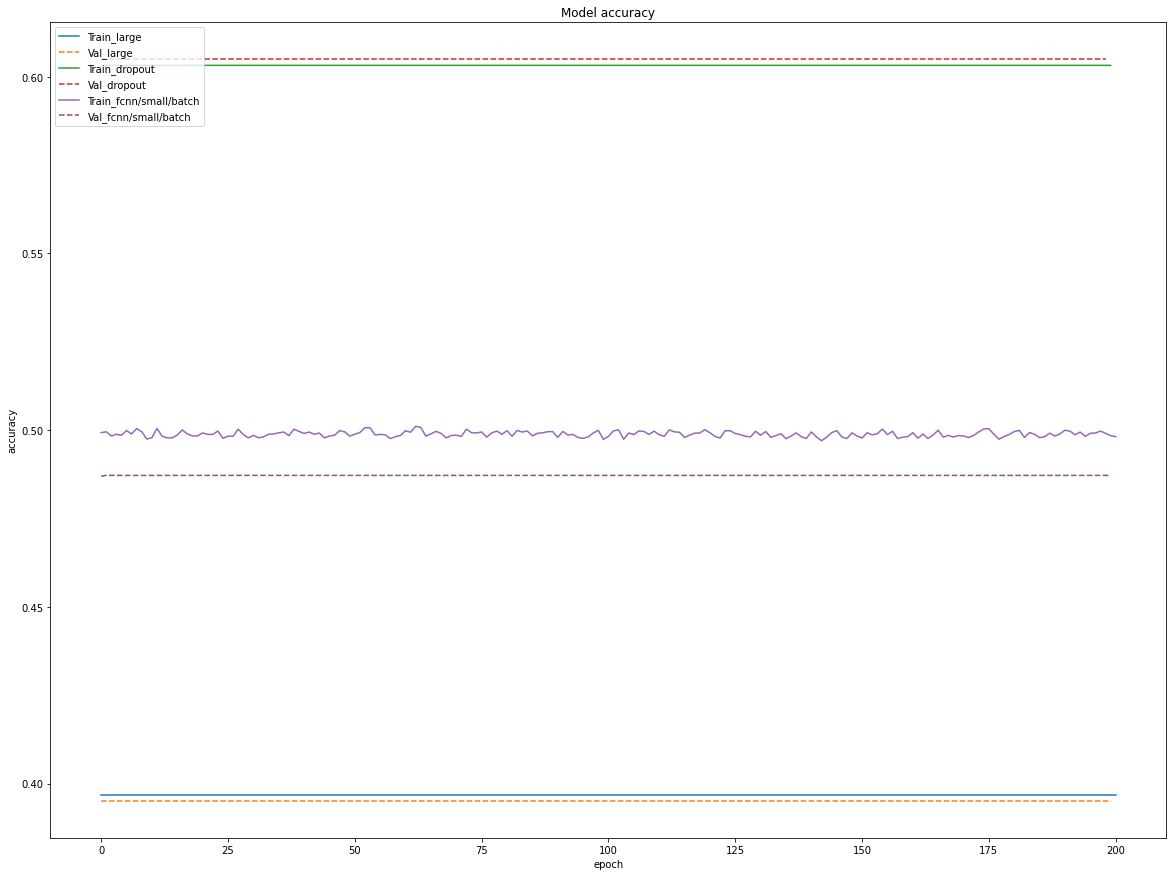

In [35]:
plot_report(batch_histories, 'accuracy')

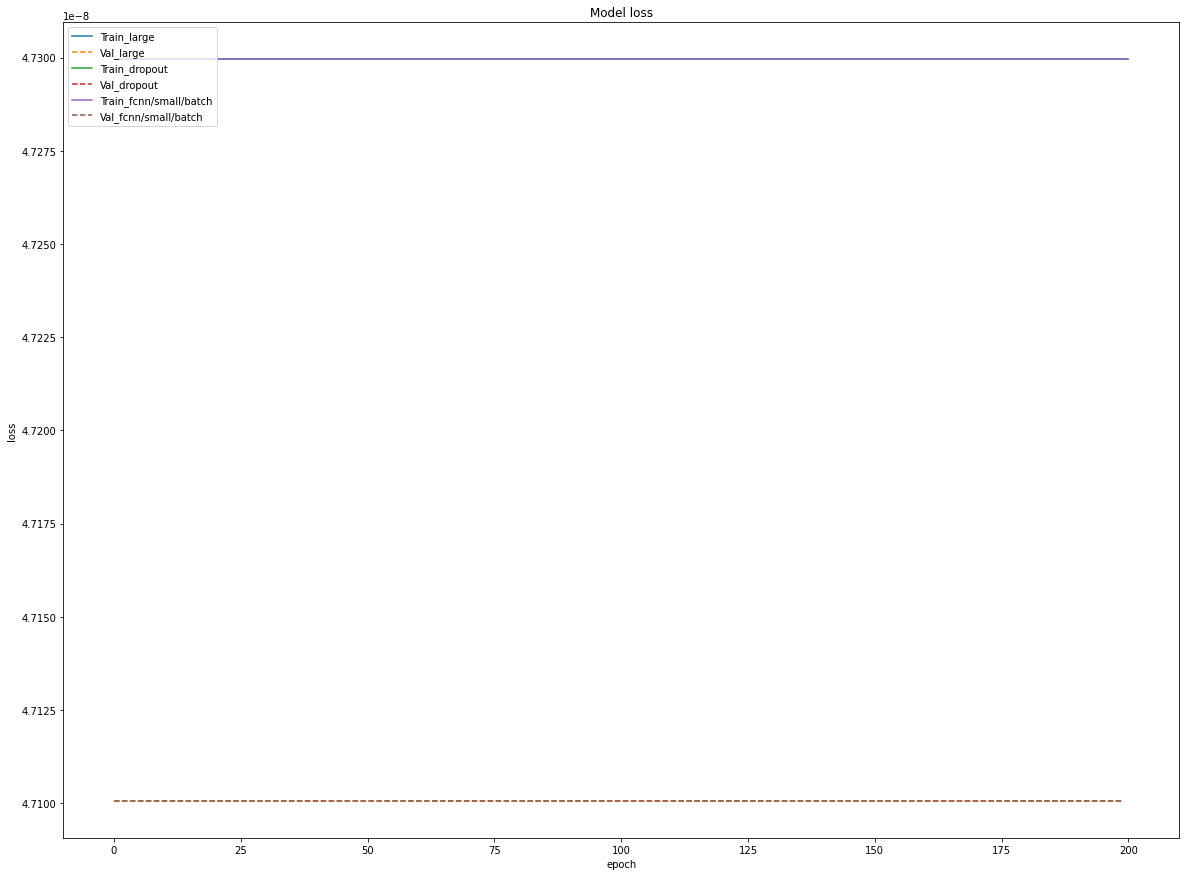

In [36]:
plot_report(batch_histories, 'loss')

## LSTM-FCNN

Univariate time series classification model, the Long Short Term Memory Fully Convolutional Network (LSTM-FCN) to capture time related information

In [37]:
lstm_histories = {}
lstm_histories['large'] = size_histories['fcnn/large']
lstm_histories['dropout'] = size_histories['fcnn/tiny/dropout']

In [38]:
lstm_units=128
lstm_tiny_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1),# expand the dimension form (50, 4096) to (50, 4096, 1)
                      input_shape=[num_features,]),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
                        kernel_regularizer=regularizers.l2(lr2)
                        ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
#     tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/tiny'] = compile_and_fit(lstm_tiny_model, 
                                               train_dataset, 
                                               test_dataset, 
                                               optimizer=tf.keras.optimizers.Adam(lr), 
#                                                optimizer=get_optimizer(int(round(size/mini_batch_size)),
#                                                                        lr=1e-4,
#                                                                        multiplier=10),
                                               name="lstm/tiny")

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('test acc:', max(lstm_histories['lstm/tiny'].history["val_accuracy"]))
print('train acc:', max(lstm_histories['lstm/tiny'].history["accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 50)             0         
                                                                 
 lstm (LSTM)                 (None, 128)               91648     
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 8)                 1032      
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 93,201
Trainable params: 92,945
Non-trainable params: 256
__________________________________________________

281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 48/1000
281/281 [==============================] - 1s 4ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 49/1000
281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 50/1000
281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 51/1000
281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 52/1000
281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 53/1000
281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accura

281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 101/1000
281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 102/1000
281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 103/1000
281/281 [==============================] - 1s 4ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 104/1000
281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 105/1000
281/281 [==============================] - 1s 4ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 106/1000
281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - 

281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 154/1000
281/281 [==============================] - 1s 4ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 155/1000
281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 156/1000
281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 157/1000
281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 158/1000
281/281 [==============================] - 1s 3ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 159/1000
281/281 [==============================] - 1s 4ms/step - loss: 4.7299e-08 - 

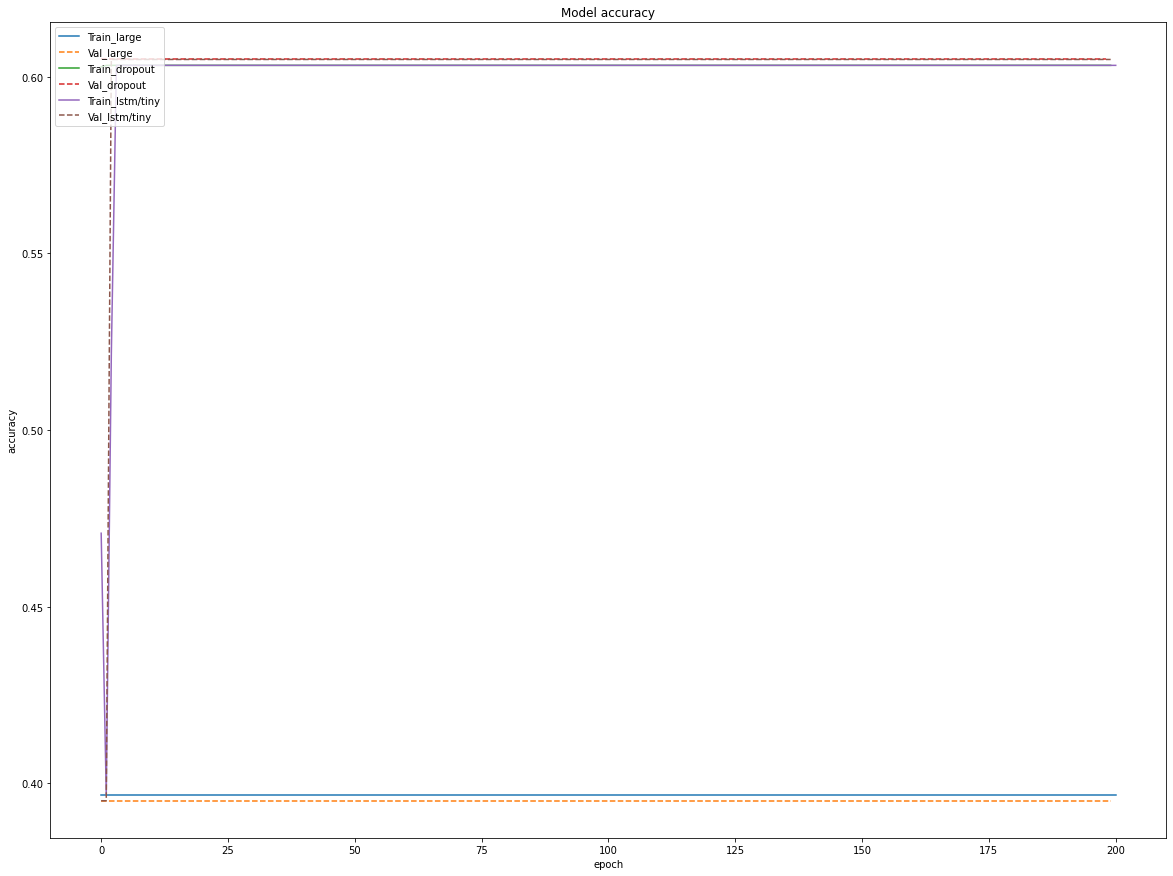

In [39]:
plot_report(lstm_histories, 'accuracy')

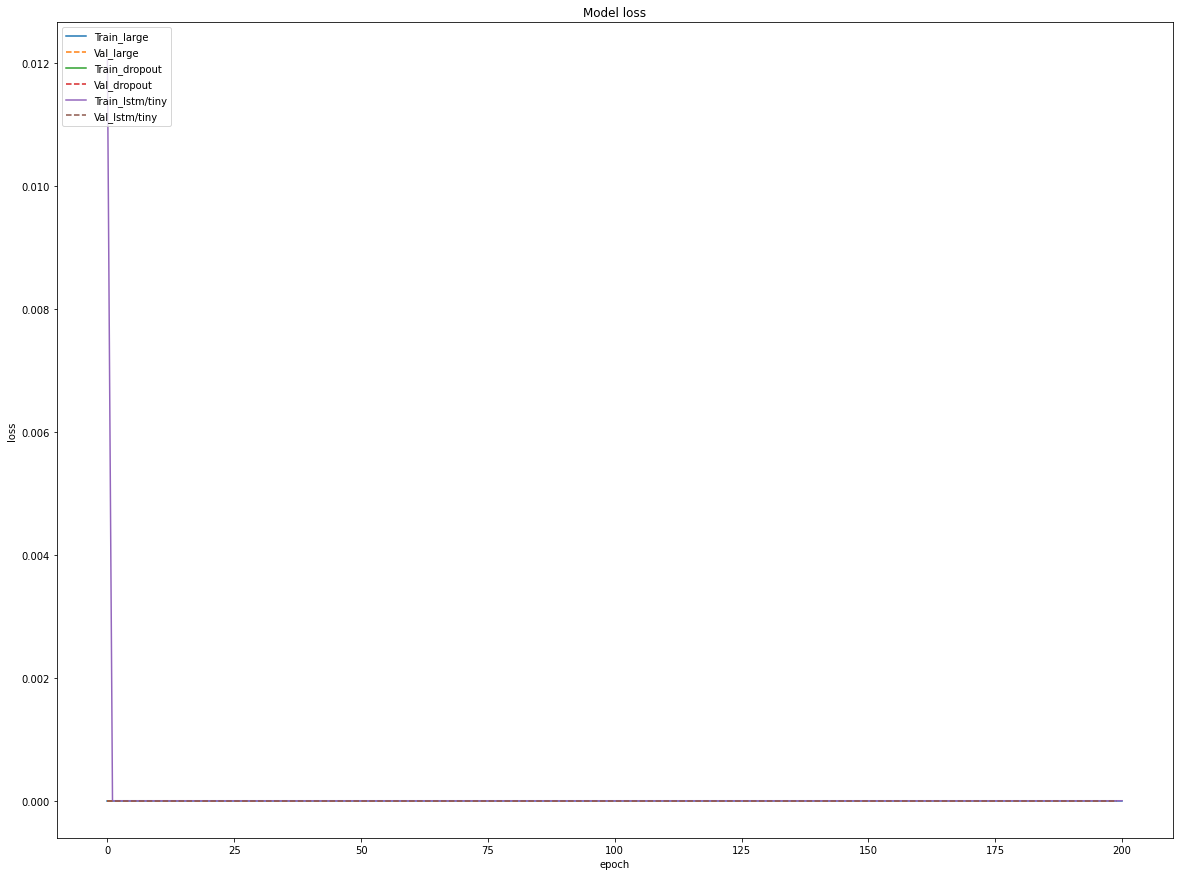

In [40]:
plot_report(lstm_histories, 'loss')

In [41]:
lstm_small_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1),# expand the dimension form (50, 4096) to (50, 4096, 1)
                      input_shape=[num_features,]),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=True,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/small'] = compile_and_fit(lstm_small_model, 
                                               train_dataset, 
                                               test_dataset, 
                                               optimizer=tf.keras.optimizers.Adam(lr), 
#                                                optimizer=get_optimizer(int(round(size/mini_batch_size)),
#                                                                        lr=1e-4,
#                                                                        multiplier=10),
                                               name="lstm/small")

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(lstm_histories['lstm/small'].history["accuracy"]))
print('test acc:', max(lstm_histories['lstm/small'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 50)             0         
                                                                 
 lstm (LSTM)                 (None, 1, 128)            91648     
                                                                 
 batch_normalization (BatchN  (None, 1, 128)           512       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 8)                 1

281/281 [==============================] - 1s 4ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 45/1000
281/281 [==============================] - 1s 5ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 46/1000
281/281 [==============================] - 1s 4ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 47/1000
281/281 [==============================] - 1s 4ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 48/1000
281/281 [==============================] - 1s 4ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 49/1000
281/281 [==============================] - 1s 4ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 50/1000
281/281 [==============================] - 1s 4ms/step - loss: 4.7299e-08 - accura

281/281 [==============================] - 1s 5ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 98/1000
281/281 [==============================] - 1s 5ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 99/1000
281/281 [==============================] - 2s 6ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 100/1000
281/281 [==============================] - 1s 5ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 101/1000
281/281 [==============================] - 1s 4ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 102/1000
281/281 [==============================] - 1s 5ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 103/1000
281/281 [==============================] - 1s 5ms/step - loss: 4.7299e-08 - ac

281/281 [==============================] - 1s 5ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 151/1000
281/281 [==============================] - 1s 5ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 152/1000
281/281 [==============================] - 1s 5ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 153/1000
281/281 [==============================] - 1s 5ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 154/1000
281/281 [==============================] - 1s 5ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 155/1000
281/281 [==============================] - 1s 5ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 156/1000
281/281 [==============================] - 1s 5ms/step - loss: 4.7299e-08 - 

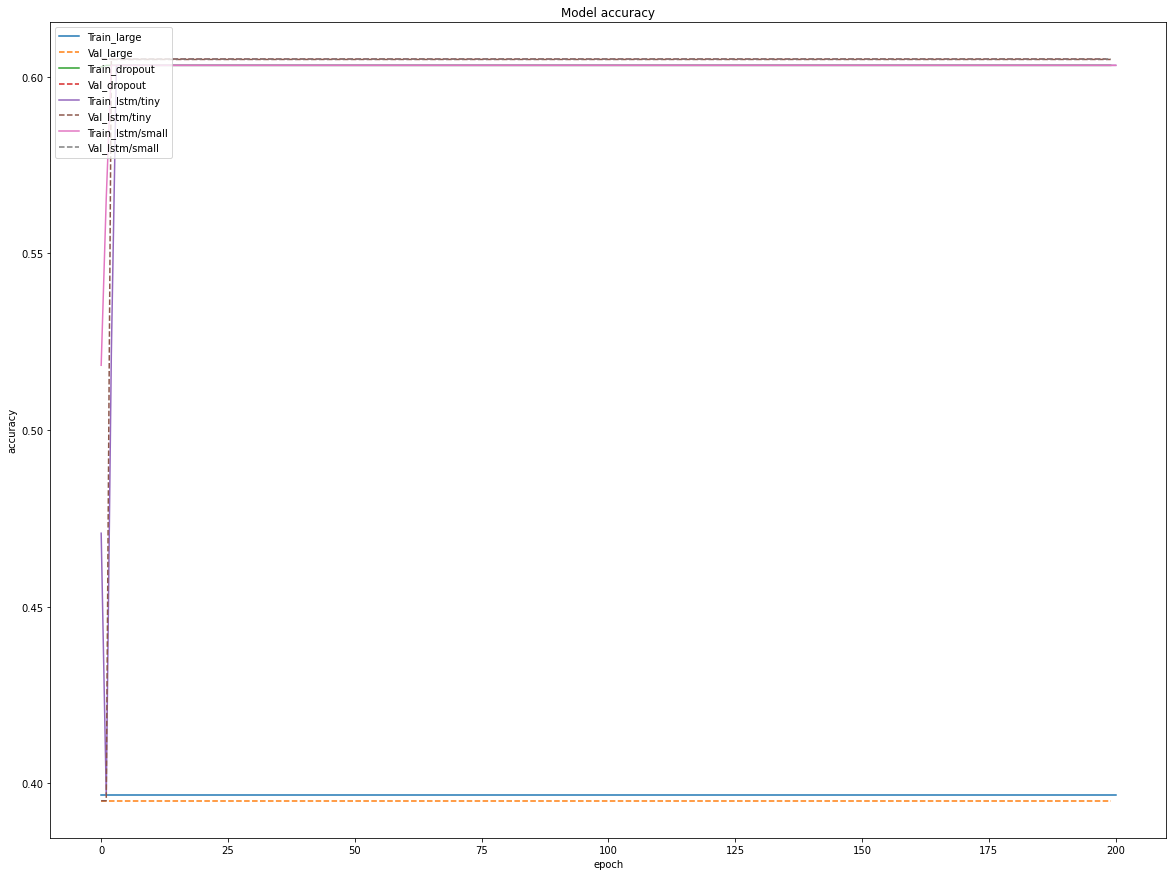

In [42]:
plot_report(lstm_histories, 'accuracy')

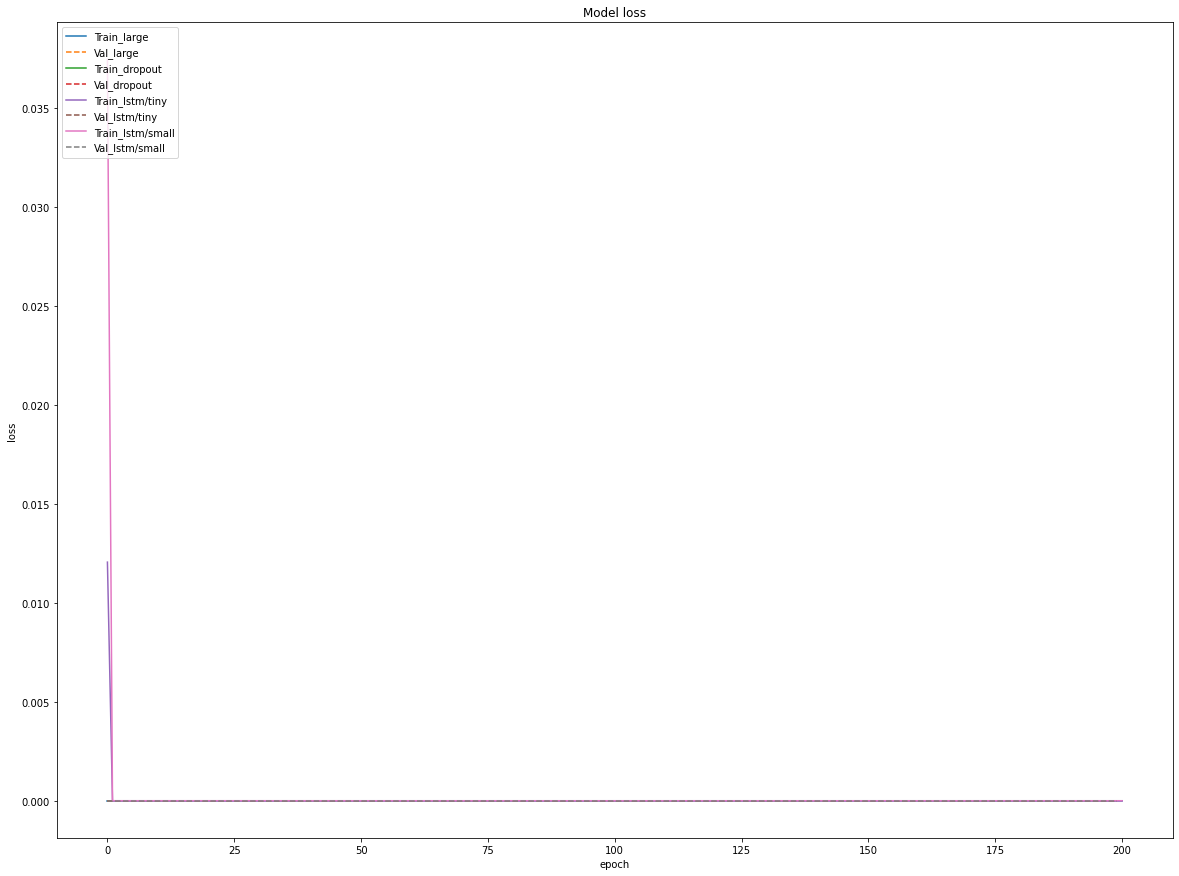

In [43]:
plot_report(lstm_histories, 'loss')

In [47]:
lstm_units=515
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_large_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1),# expand the dimension form (50, 4096) to (50, 4096, 1)
                      input_shape=[num_features,]),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=True,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/large'] = compile_and_fit(lstm_large_model, 
                                               train_dataset, 
                                               test_dataset, 
                                               optimizer=tf.keras.optimizers.Adam(lr), 
#                                                optimizer=get_optimizer(int(round(size/mini_batch_size)),
#                                                lr=1e-4,
#                                                multiplier=10), 
                                                name="lstm/large")

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(lstm_histories['lstm/large'].history["accuracy"]))
print('test acc:', max(lstm_histories['lstm/large'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 50)             0         
                                                                 
 lstm (LSTM)                 (None, 1, 515)            1165960   
                                                                 
 batch_normalization (BatchN  (None, 1, 515)           2060      
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 515)               2123860   
                                                                 
 batch_normalization_1 (Batc  (None, 515)              2060      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 64)                3

281/281 [==============================] - 2s 7ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 37/1000
281/281 [==============================] - 2s 7ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 38/1000
281/281 [==============================] - 2s 7ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 39/1000
281/281 [==============================] - 2s 7ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 40/1000
281/281 [==============================] - 2s 7ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 41/1000
281/281 [==============================] - 2s 8ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 42/1000
281/281 [==============================] - 2s 8ms/step - loss: 4.7299e-08 - accura

281/281 [==============================] - 2s 7ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 90/1000
281/281 [==============================] - 2s 7ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 91/1000
281/281 [==============================] - 2s 7ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 92/1000
281/281 [==============================] - 2s 7ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 93/1000
281/281 [==============================] - 2s 7ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 94/1000
281/281 [==============================] - 2s 7ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 95/1000
281/281 [==============================] - 2s 7ms/step - loss: 4.7299e-08 - accura

281/281 [==============================] - 2s 7ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 143/1000
281/281 [==============================] - 2s 7ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 144/1000
281/281 [==============================] - 2s 7ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 145/1000
281/281 [==============================] - 2s 7ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 146/1000
281/281 [==============================] - 2s 8ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 147/1000
281/281 [==============================] - 2s 7ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 148/1000
281/281 [==============================] - 2s 7ms/step - loss: 4.7299e-08 - 

281/281 [==============================] - 2s 8ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 196/1000
281/281 [==============================] - 2s 8ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 197/1000
281/281 [==============================] - 2s 7ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 198/1000
281/281 [==============================] - 2s 7ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 199/1000
281/281 [==============================] - 2s 8ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 200/1000
281/281 [==============================] - 2s 7ms/step - loss: 4.7299e-08 - accuracy: 0.6032 - val_loss: 4.7101e-08 - val_accuracy: 0.6049
Epoch 201/1000
281/281 [==============================] - 2s 7ms/step - loss: 4.7299e-08 - 

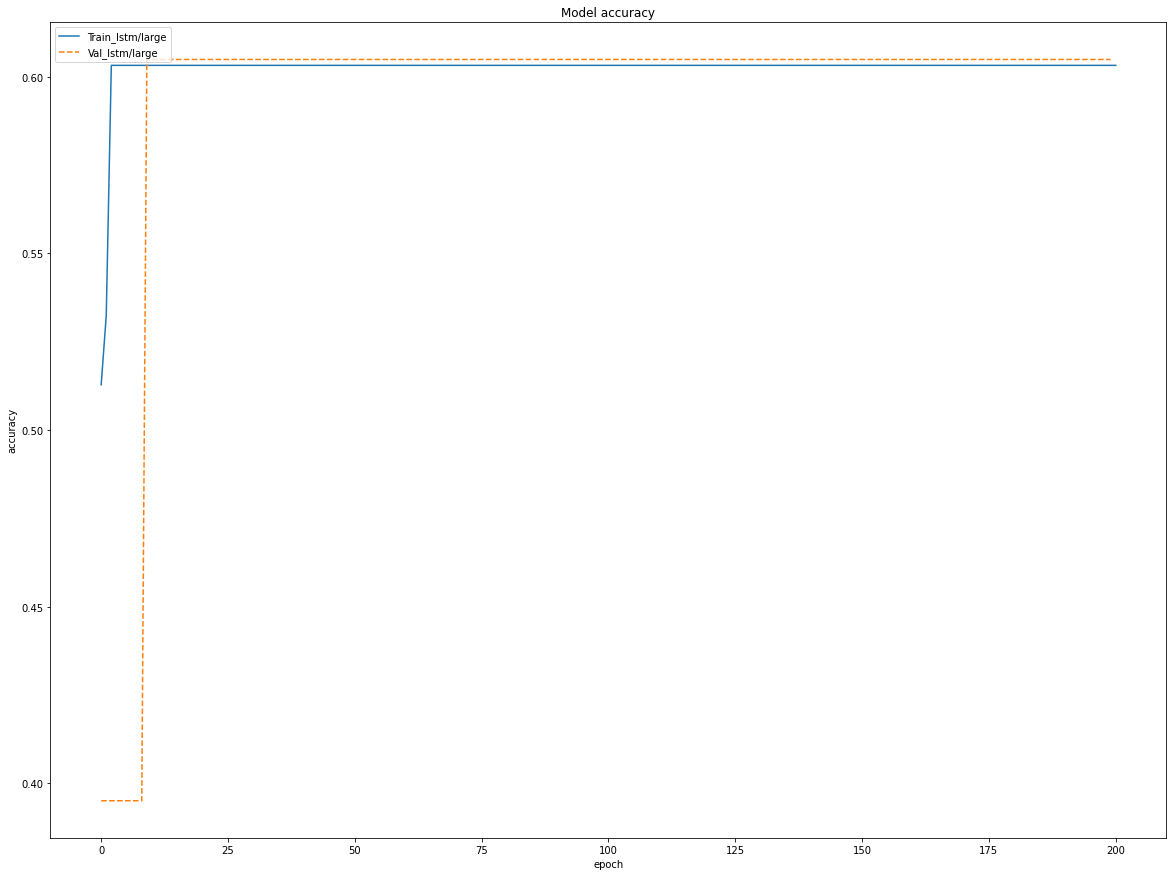

In [45]:
plot_report({'lstm/large':lstm_histories['lstm/large']}, 'accuracy')

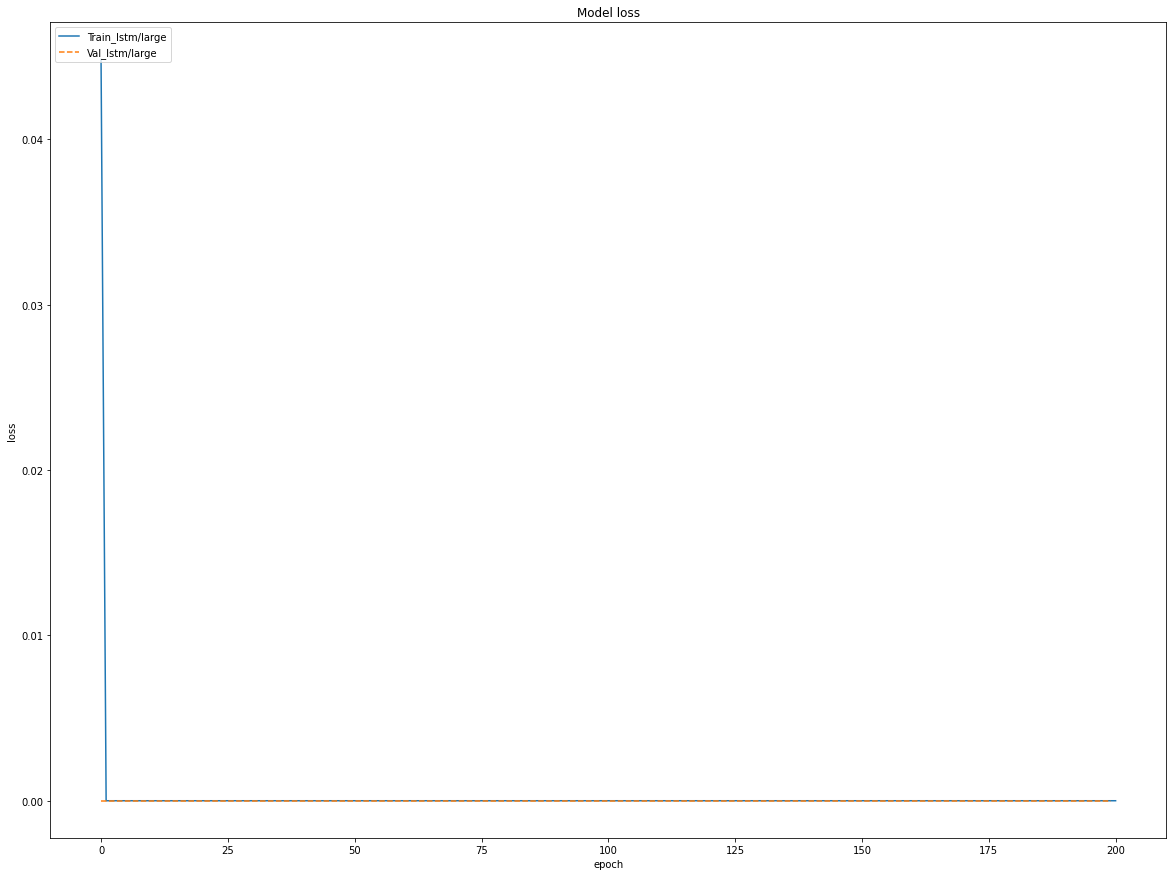

In [46]:
plot_report({'lstm/large':lstm_histories['lstm/large']}, 'loss')